In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from functions import *
import folium

In [2]:
spark = SparkSession.builder \
   .master("local") \
   .appName("DataExp") \
   .config("spark.executor.memory", "8gb") \
   .getOrCreate()

sc = spark.sparkContext

In [3]:
# per evitare di avere troppe combinazioni di dati da analizzare, utilizzo solo i dati dello Scenario 1 (PVS1,PVS4,PVS7)
pvs1 = dataset_preparation('PVS1', spark, 'data')
pvs4 = dataset_preparation('PVS4', spark, 'data')
pvs7 = dataset_preparation('PVS7', spark, 'data')

In [4]:
len(pvs1.columns)

59

In [5]:
pvs1.columns

['timestep',
 'latitude',
 'longitude',
 'speed',
 'acc_x_dashboard_L',
 'acc_y_dashboard_L',
 'acc_z_dashboard_L',
 'acc_x_above_suspension_L',
 'acc_y_above_suspension_L',
 'acc_z_above_suspension_L',
 'acc_x_below_suspension_L',
 'acc_y_below_suspension_L',
 'acc_z_below_suspension_L',
 'gyro_x_dashboard_L',
 'gyro_y_dashboard_L',
 'gyro_z_dashboard_L',
 'gyro_x_above_suspension_L',
 'gyro_y_above_suspension_L',
 'gyro_z_above_suspension_L',
 'gyro_x_below_suspension_L',
 'gyro_y_below_suspension_L',
 'gyro_z_below_suspension_L',
 'mag_x_dashboard_L',
 'mag_y_dashboard_L',
 'mag_z_dashboard_L',
 'mag_x_above_suspension_L',
 'mag_y_above_suspension_L',
 'mag_z_above_suspension_L',
 'temp_dashboard_L',
 'temp_above_suspension_L',
 'temp_below_suspension_L',
 'acc_x_dashboard_R',
 'acc_y_dashboard_R',
 'acc_z_dashboard_R',
 'acc_x_above_suspension_R',
 'acc_y_above_suspension_R',
 'acc_z_above_suspension_R',
 'acc_x_below_suspension_R',
 'acc_y_below_suspension_R',
 'acc_z_below_suspen

## Parte 1: Distribuzione delle feature sullo Scenario

Ho scelto arbitrariamente solo alcune feature da ogni gruppo da analizzare, sarebbe inutile e troppo complesso analizzarle tutte.
Per le feature analizzate saranno mostrate la media e la deviazione standard.

Inoltre per evitare grafici confusionari, realizzerò i grafici solo per il guidatore 1 (PVS1).

Per fare i grafici le time series originali saranno approssimate per ridurne di molto la lunghezza e poi farò il collect.

In [6]:
# lista di feature che voglio analizzare
features = ['speed', 'acc_x_dashboard_L', 'acc_y_dashboard_L', 'acc_z_dashboard_L', 'acc_z_dashboard_R', 'gyro_x_dashboard_L', 'gyro_y_dashboard_L',\
            'temp_dashboard_L', 'mag_x_dashboard_L', 'mag_y_dashboard_L', 'mag_z_dashboard_L']

# alla funzione devo dare come parametro la lista delle "funzioni aggregative"
feat_funct = [F.avg(f).alias(f) for f in features] + [F.std(f).alias(f'std_{f}') for f in features]

In [7]:
pvs1.show()

+--------+-------------------+------------------+-----------+-------------------+-------------------+-----------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+-------------------+--------------------+------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+------------------+-------------------+------------------+------------------------+------------------------+------------------------+------------------+-----------------------+-----------------------+-------------------+-------------------+-----------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+--------------------+-------------------+--------------------+-------------------------+-------------------

In [ ]:
# approssimo la time series con un rapporto 200:1 per poterla plottare
approx_pvs1 = approximate_ts(pvs1, feat_funct, 200)

In [9]:
print('Lunghezza time series dopo approssimazione: ' + str(approx_pvs1.count()))

Lunghezza time series dopo approssimazione: 721


In [10]:
approx_pvs1.columns

['group_by',
 'timestep',
 'road_condition',
 'latitude',
 'longitude',
 'speed',
 'acc_x_dashboard_L',
 'acc_y_dashboard_L',
 'acc_z_dashboard_L',
 'acc_z_dashboard_R',
 'gyro_x_dashboard_L',
 'gyro_y_dashboard_L',
 'temp_dashboard_L',
 'mag_x_dashboard_L',
 'mag_y_dashboard_L',
 'mag_z_dashboard_L',
 'std_speed',
 'std_acc_x_dashboard_L',
 'std_acc_y_dashboard_L',
 'std_acc_z_dashboard_L',
 'std_acc_z_dashboard_R',
 'std_gyro_x_dashboard_L',
 'std_gyro_y_dashboard_L',
 'std_temp_dashboard_L',
 'std_mag_x_dashboard_L',
 'std_mag_y_dashboard_L',
 'std_mag_z_dashboard_L']

In [11]:
# la time series è molto piccola ora quindi posso usare Pandas
pvs1_pd = approx_pvs1.toPandas()

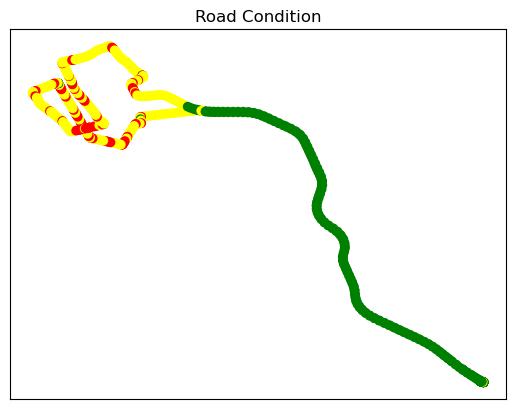

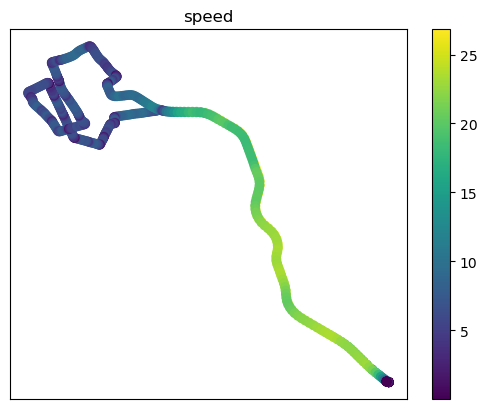

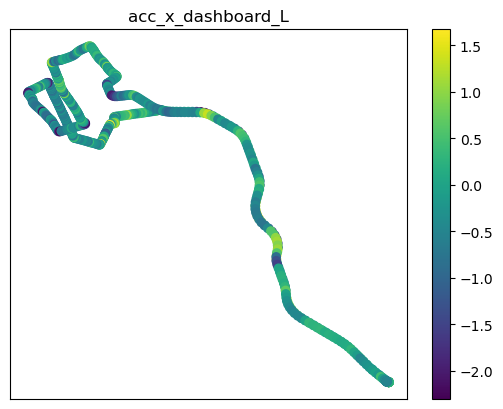

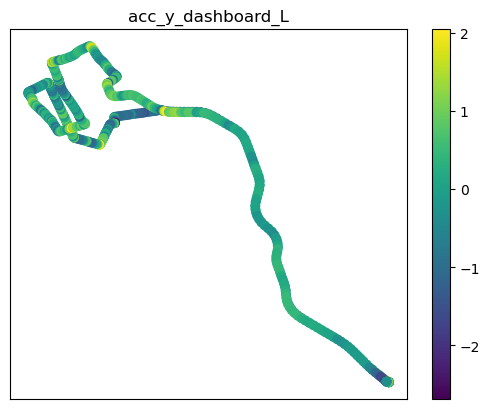

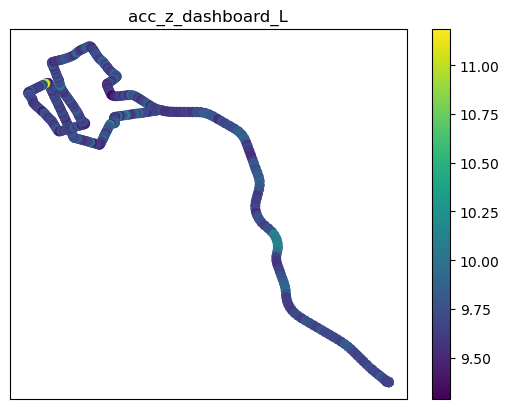

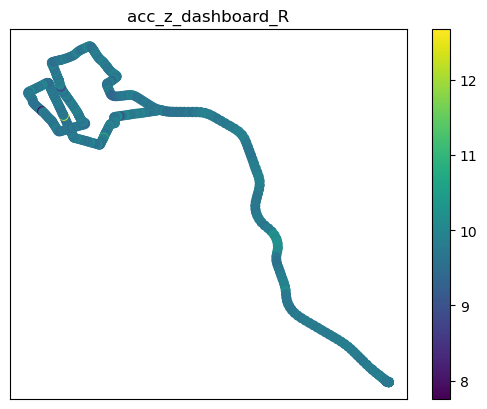

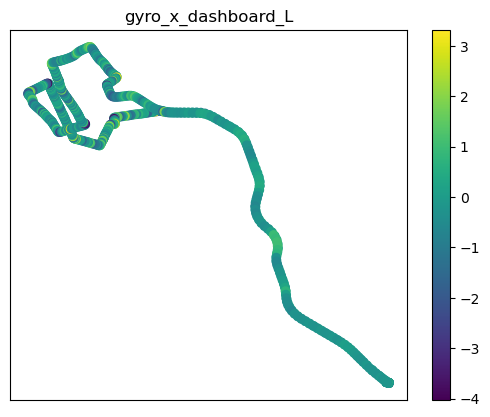

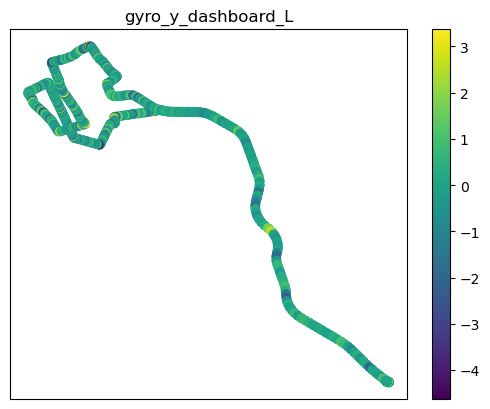

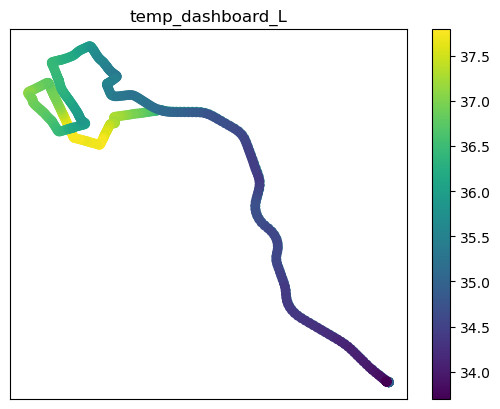

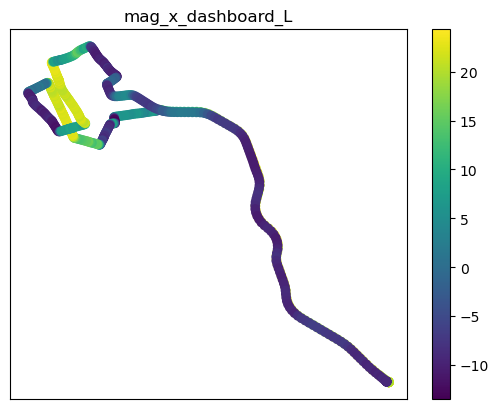

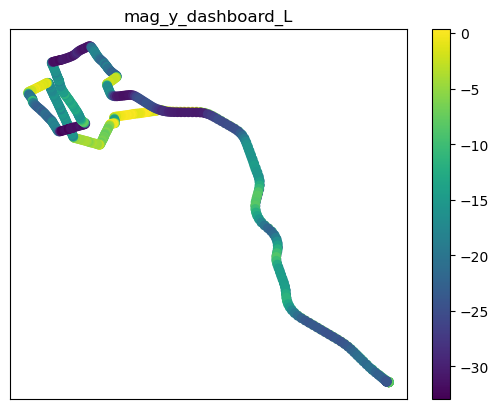

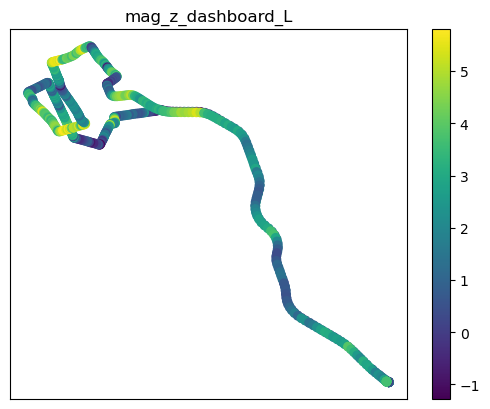

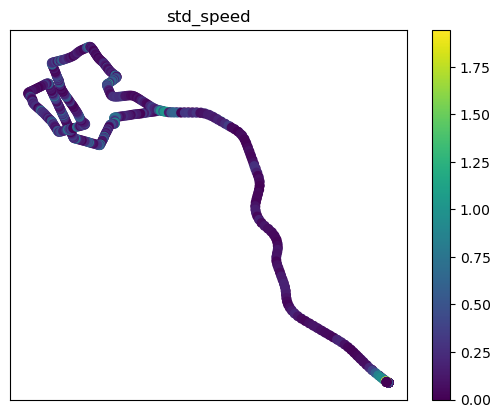

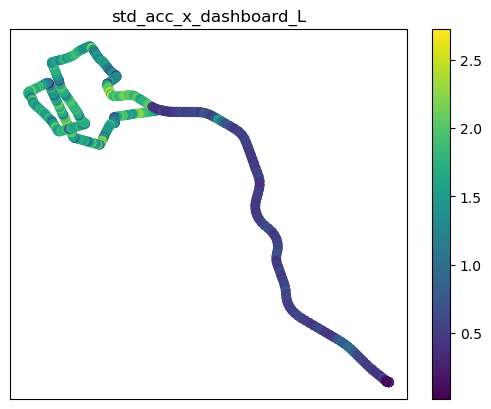

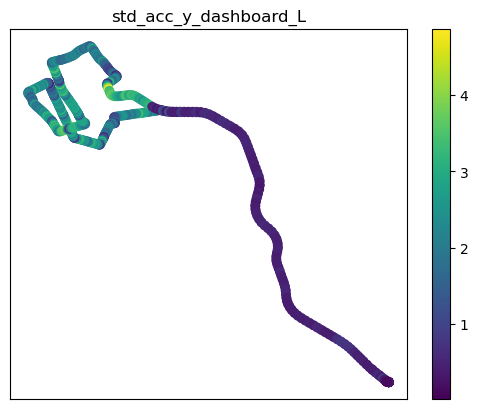

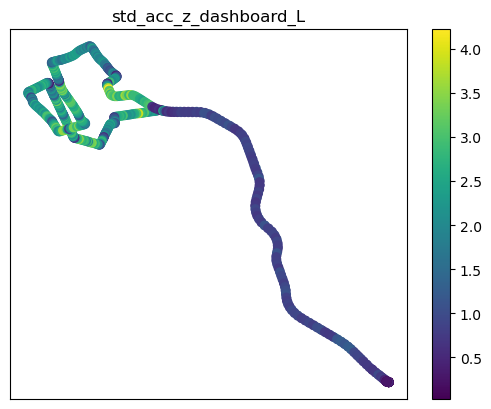

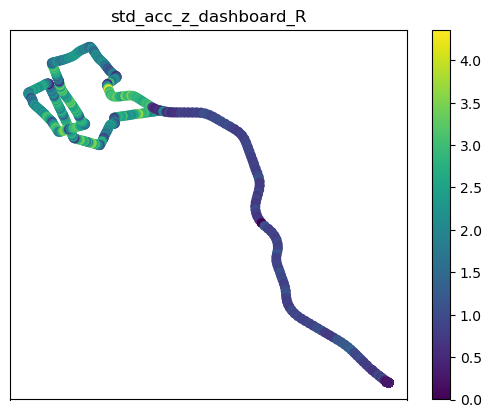

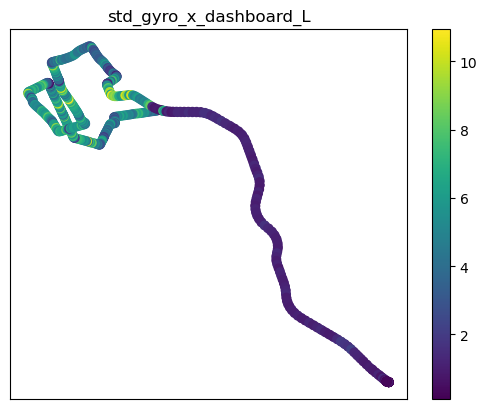

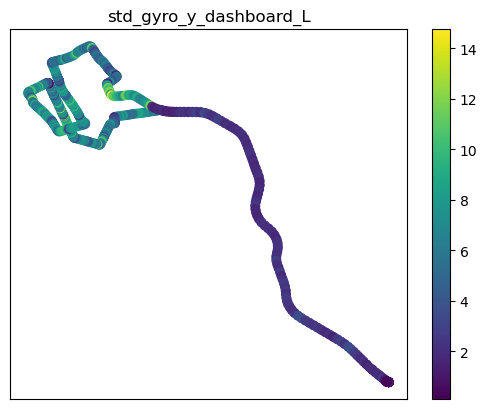

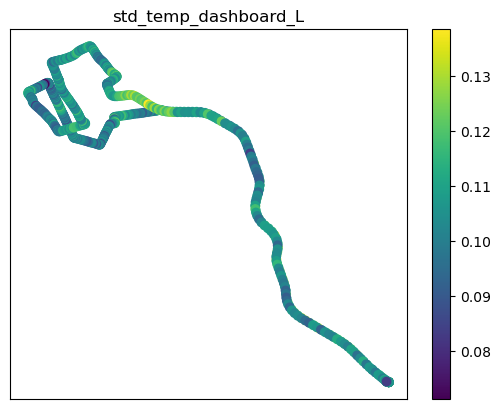

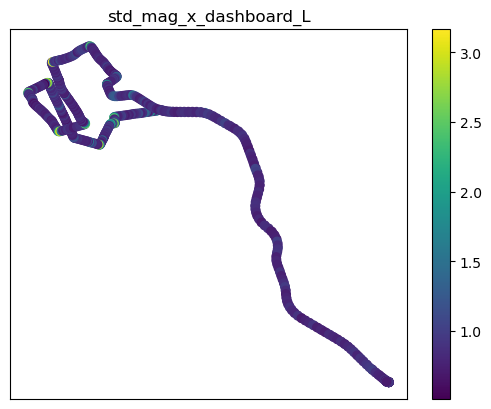

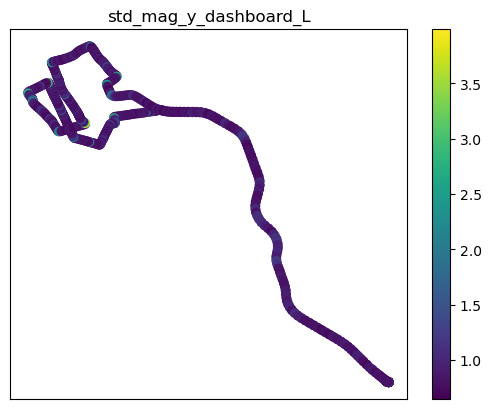

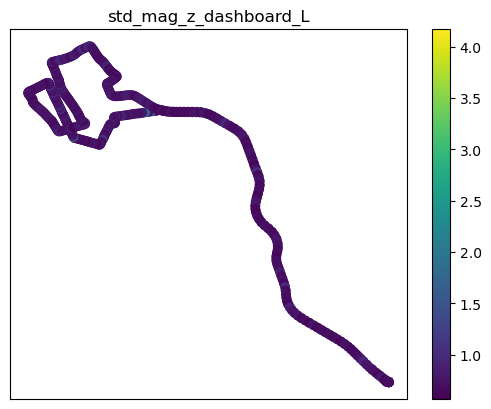

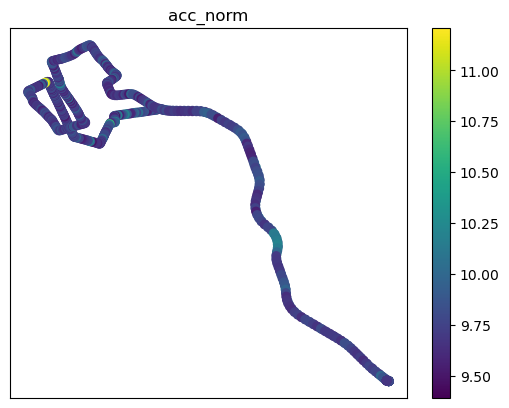

In [37]:
# prima faccio i grafici con matplotlib, poi per le features più interessanti farò dei grafici interattivi con folium per mostrare anche la rete stradale

color_map = {
    'good': 'green',    # Verde per la classe "good"
    'regular': 'yellow',  # Giallo per la classe "regular"
    'bad': 'red'        # Rosso per la classe "bad"
}

plt.scatter(pvs1_pd['longitude'], pvs1_pd['latitude'], c=[color_map[x] for x in pvs1_pd['road_condition']])
plt.title('Road Condition')
plt.xticks([])
plt.yticks([])
plt.show()


for col in pvs1_pd.columns[5:]:
    plt.scatter(pvs1_pd['longitude'], pvs1_pd['latitude'], c=pvs1_pd[col])
    plt.colorbar()
    plt.title(col)
    plt.xticks([])
    plt.yticks([])
    plt.show()

### Road Condition Label Plot

In [38]:
color_map_rgb = {
    'good': '#008000',       
    'regular': '#FFFF00',   
    'bad': '#FF0000'        
}

map_center = [pvs1_pd['latitude'].mean(), pvs1_pd['longitude'].mean()]
map = folium.Map(location=map_center, zoom_start=14, width=500, height=700)

for _, row in pvs1_pd.iterrows():
    color = color_map_rgb[row['road_condition']]
    
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=3,
        color=color,                
        fill=True,
        fill_color=color,           
        fill_opacity=0.7,
    ).add_to(map)

# Visualizza la mappa
map

### Speed Plot

In [40]:
import branca.colormap as cm

pvs1_pd['speed_kmh'] = pvs1_pd['speed'] * 3.6

map_center = [pvs1_pd['latitude'].mean(), pvs1_pd['longitude'].mean()]
map = folium.Map(location=map_center, zoom_start=14, width=500, height=700)

min_speed = pvs1_pd['speed_kmh'].min()
max_speed = pvs1_pd['speed_kmh'].max()
colormap = cm.LinearColormap(['yellow', 'green', 'blue'], vmin=min_speed, vmax=max_speed, caption="Speed (km/h)")

for _, row in pvs1_pd.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=3,
        color=colormap(row['speed_kmh']), 
        fill=True,
        fill_color=colormap(row['speed_kmh']),
        fill_opacity=0.7,
        tooltip=f"Speed: {row['speed_kmh']:.1f} km/h"
    ).add_to(map)

colormap.add_to(map)

map

### Std Acc Z Dashboard Plot

In [41]:
map_center = [pvs1_pd['latitude'].mean(), pvs1_pd['longitude'].mean()]
map = folium.Map(location=map_center, zoom_start=14, width=500, height=700)

min = pvs1_pd['std_acc_z_dashboard_L'].min()
max = pvs1_pd['std_acc_z_dashboard_L'].max()
colormap = cm.LinearColormap(['yellow', 'green', 'blue'], vmin=min, vmax=max, caption="Std. of Acceleration on Z axis m/s^2 (Dashboard L)")

for _, row in pvs1_pd.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=3,
        color=colormap(row['std_acc_z_dashboard_L']), 
        fill=True,
        fill_color=colormap(row['std_acc_z_dashboard_L']),
        fill_opacity=0.7,
    ).add_to(map)

colormap.add_to(map)

map

### Acc Dashboard X Plot 

In [42]:
map_center = [pvs1_pd['latitude'].mean(), pvs1_pd['longitude'].mean()]
map = folium.Map(location=map_center, zoom_start=14, width=500, height=700)

min = pvs1_pd['acc_x_dashboard_L'].min()
max = pvs1_pd['acc_x_dashboard_L'].max()
colormap = cm.LinearColormap(['yellow', 'green', 'blue'], vmin=min, vmax=max, caption="Acceleration on X axis m/s^2 (Dashboard L)")

for _, row in pvs1_pd.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=3,
        color=colormap(row['acc_x_dashboard_L']), 
        fill=True,
        fill_color=colormap(row['acc_x_dashboard_L']),
        fill_opacity=0.7,
    ).add_to(map)

colormap.add_to(map)

map

### Acc Dashboard Y Plot

In [44]:
map_center = [pvs1_pd['latitude'].mean(), pvs1_pd['longitude'].mean()]
map = folium.Map(location=map_center, zoom_start=14, width=500, height=700)

min = pvs1_pd['acc_y_dashboard_L'].min()
max = pvs1_pd['acc_y_dashboard_L'].max()
colormap = cm.LinearColormap(['yellow', 'green', 'blue'], vmin=min, vmax=max, caption="Acceleration on Y axis m/s^2 (Dashboard L)")

for _, row in pvs1_pd.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=3,
        color=colormap(row['acc_y_dashboard_L']), 
        fill=True,
        fill_color=colormap(row['acc_y_dashboard_L']),
        fill_opacity=0.7,
    ).add_to(map)

colormap.add_to(map)
map

### Mag Z Dashboard L Plot

In [47]:
map_center = [pvs1_pd['latitude'].mean(), pvs1_pd['longitude'].mean()]
map = folium.Map(location=map_center, zoom_start=14, width=500, height=700)

min = pvs1_pd['mag_z_dashboard_L'].min()
max = pvs1_pd['mag_z_dashboard_L'].max()
colormap = cm.LinearColormap(['yellow', 'green', 'blue'], vmin=min, vmax=max, caption="Ambient Geomagnetic Field on Z axis µT (Dashboard L)")

for _, row in pvs1_pd.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=3,
        color=colormap(row['mag_z_dashboard_L']), 
        fill=True,
        fill_color=colormap(row['mag_z_dashboard_L']),
        fill_opacity=0.7,
    ).add_to(map)

colormap.add_to(map)
map

## Parte 2: Analisi della distribuzione delle feature rispetto ai diversi guidatori

In questo caso, per lo scenario 1, saranno paragonate le time series di ogni driver per 4 feature: speed, std_acc_z_dashboard_L, acc_x_dashboard_L, acc_y_dashboard_L.

In [13]:
# prendo anche i dati degli altri guidatori
approx_pvs4 = approximate_ts(pvs4, feat_funct, 200)
approx_pvs7 = approximate_ts(pvs7, feat_funct, 200)

In [14]:
approx_pvs4.count(), approx_pvs7.count()

(663, 643)

In [15]:
pvs4_pd = approx_pvs4.toPandas()
pvs7_pd = approx_pvs7.toPandas()

calcolo un'approssimazione della distanza percorsa: il GPS aveva un sampling rate di 1HZ, la time series originale aveva un timestep distanziato di 0.01 secondi, ho compresso la time series originale in scala 200:1, quindi in ogni timestep attuale è distanziato di 2 secondi (0.01x200), quindi posso calcolare la distanza percorsa con 2*speed, calcolo però la distanza cumulativa, sommando anche i precedenti. I risultati sembrano una discreta approssimazione di quelli dichiarati nel sito del dataset, c'è un margine di errore, ma tanto mi servono solo per fare dei grafici senza shift dovuti alla velocità diversa dei guidatori, e non per altro.

In [16]:
pvs1_pd['distance'] = np.array([pvs1_pd.iloc[i]['speed']+sum(pvs1_pd[:i]['speed']) for i in range(len(pvs1_pd))]) * 2
pvs1_pd['distance'].iloc[-1]

13765.344326236747

In [17]:
pvs4_pd['distance'] = np.array([pvs4_pd.iloc[i]['speed']+sum(pvs4_pd[:i]['speed']) for i in range(len(pvs4_pd))]) * 2
pvs4_pd['distance'].iloc[-1]

13763.081803337749

In [18]:
pvs7_pd['distance'] = np.array([pvs7_pd.iloc[i]['speed']+sum(pvs7_pd[:i]['speed']) for i in range(len(pvs7_pd))]) * 2
pvs7_pd['distance'].iloc[-1]

13746.620745237531

### Drivers Speed Scenario 1

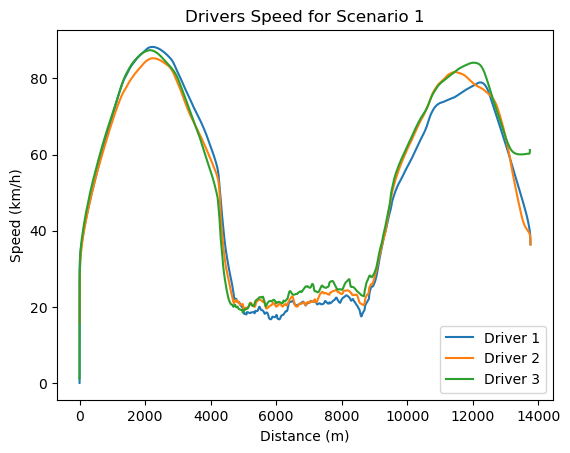

In [19]:
plt.plot(pvs1_pd['distance'], moving_average(pvs1_pd['speed']*3.6,64), label='Driver 1')
plt.plot(pvs4_pd['distance'], moving_average(pvs4_pd['speed']*3.6,64), label='Driver 2')
plt.plot(pvs7_pd['distance'], moving_average(pvs7_pd['speed']*3.6,64), label='Driver 3')
plt.legend()
plt.xlabel('Distance (m)')
plt.ylabel('Speed (km/h)')
plt.title('Drivers Speed for Scenario 1')
plt.show()

### Drivers Std of Acceleration on Z Axis Scenario 1

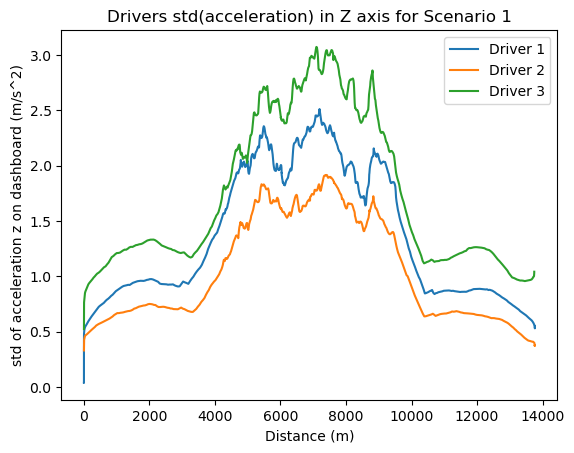

In [23]:
plt.plot(pvs1_pd['distance'], moving_average(pvs1_pd['std_acc_z_dashboard_L'],64), label='Driver 1')
plt.plot(pvs4_pd['distance'], moving_average(pvs4_pd['std_acc_z_dashboard_L'],64), label='Driver 2')
plt.plot(pvs7_pd['distance'], moving_average(pvs7_pd['std_acc_z_dashboard_L'],64), label='Driver 3')
plt.legend()
plt.xlabel('Distance (m)')
plt.ylabel('std of acceleration z on dashboard (m/s^2)')
plt.title('Drivers std(acceleration) in Z axis for Scenario 1')
plt.show()

### Drivers Acceleration on X Axis Scenario 1

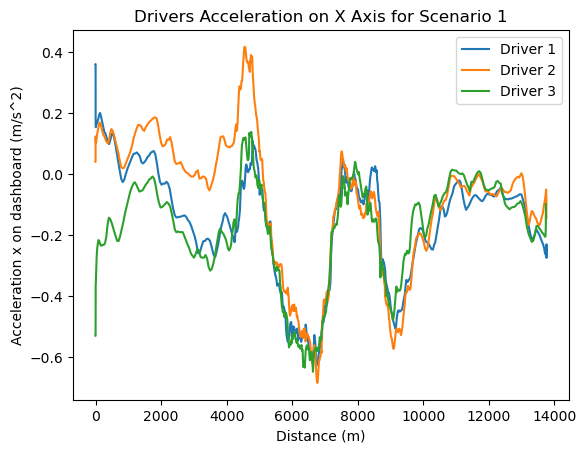

In [21]:
plt.plot(pvs1_pd['distance'], moving_average(pvs1_pd['acc_x_dashboard_L'],64), label='Driver 1')
plt.plot(pvs4_pd['distance'], moving_average(pvs4_pd['acc_x_dashboard_L'],64), label='Driver 2')
plt.plot(pvs7_pd['distance'], moving_average(pvs7_pd['acc_x_dashboard_L'],64), label='Driver 3')
plt.legend()
plt.xlabel('Distance (m)')
plt.ylabel('Acceleration x on dashboard (m/s^2)')
plt.title('Drivers Acceleration on X Axis for Scenario 1')
plt.show()

### Ambient Geomagnetic Field on Z axis Scenario 1

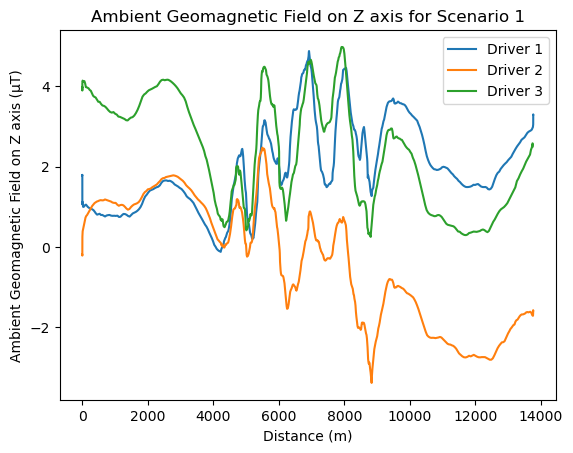

In [22]:
plt.plot(pvs1_pd['distance'], moving_average(pvs1_pd['mag_z_dashboard_L'],32), label='Driver 1')
plt.plot(pvs4_pd['distance'], moving_average(pvs4_pd['mag_z_dashboard_L'],32), label='Driver 2')
plt.plot(pvs7_pd['distance'], moving_average(pvs7_pd['mag_z_dashboard_L'],32), label='Driver 3')
plt.legend()
plt.xlabel('Distance (m)')
plt.ylabel('Ambient Geomagnetic Field on Z axis (µT)')
plt.title('Ambient Geomagnetic Field on Z axis for Scenario 1')
plt.show()